In [2]:
from tools import *
from config import *

In [18]:
p = pd.read_csv('inference/firepoint/train/full_10.csv')

In [19]:
p[p['departement'] == 1].date.min(), p[p['departement'] == 69].date.min(), p[p['departement'] == 78].date.min(), p[p['departement'] == 25].date.min()

(203, 203, 1, 1)

In [12]:
p[p['departement'] == 1].date.max(), p[p['departement'] == 69].date.max(), p[p['departement'] == 78].date.max(), p[p['departement'] == 25].date.max()

(2573, 2028, 2573, 2573)

In [2]:
def order_class(predictor, pred):
    res = np.zeros(pred[~np.isnan(pred)].shape[0], dtype=int)
    cc = predictor.cluster_centers.reshape(-1)
    classes = np.arange(cc.shape[0])
    ind = np.lexsort([cc])
    cc = cc[ind]
    classes = classes[ind]
    for c in range(cc.shape[0]):
        mask = np.argwhere(pred == classes[c])
        res[mask] = c
    return res

def class_risk(ypred, ytrue, ybin, nameDep : str, predictor) -> dict:
    if torch.is_tensor(ypred):
        ypred = ypred.detach().cpu().numpy().astype(float)
    if torch.is_tensor(ytrue):
        ytrue = ytrue.detach().cpu().numpy().astype(float)

    res = {}

    yclass = predictor.predict(ytrue)
    yclass = order_class(predictor, yclass)
    uniqueClass = np.unique(yclass)
    res[nameDep] = {}
    for c in uniqueClass:
        classIndex = np.argwhere(yclass == c)
        classPred = ypred[classIndex]
        classTrue = ypred[classIndex]
        error = abs(classPred - classTrue)
        classBin = ybin[classIndex]
        meanF = round(np.mean(classBin), 3)
        print(c, np.nansum(classBin), np.nansum(ybin))
        meanFF = round(100 * (np.nansum(classBin) / np.nansum(ybin)))
        meanP = round(np.mean(classPred), 3)
        meanT = round(np.mean(classTrue), 3)
        error = round(np.mean(error))
        res[nameDep][c] = (round(predictor.get_centroid(c)[0], 3), meanP, meanT, error, meanFF, meanF)
        
    return res[nameDep]

def get_max(influence):
    return np.nanmax(influence)

def get_sum(influence):
    return np.nansum(influence)

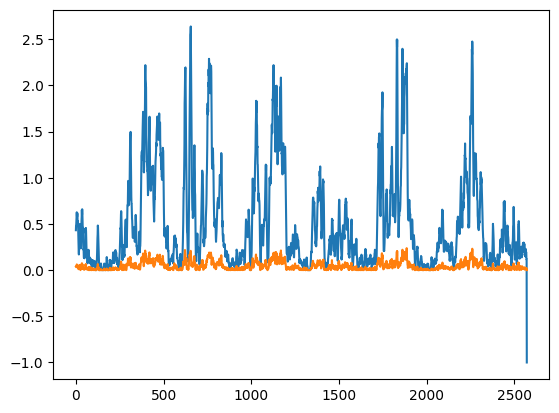

In [10]:
name_exp = 'inference'
sinister = 'firepoint'

Y = read_object('Y_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
X = read_object('X_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
pos_feature, _ = create_pos_feature(graph.scale, 6, features)
Y_by_date = []
X_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    X_by_date.append(np.mean(X[X[:,4] == d][:, pos_feature['Historical'] + 2]))

Y_by_date = np.asarray(Y_by_date)
X_by_date = np.asarray(X_by_date)
plt.plot(Y_by_date)
plt.plot(X_by_date)

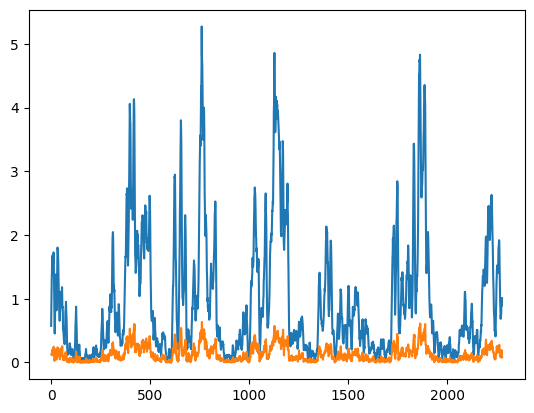

In [9]:
name_exp = 'final'
sinister = 'firepoint'

Y = read_object('Y_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
X = read_object('X_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
pos_feature, _ = create_pos_feature(graph.scale, 6, features)
Y_by_date = []
X_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    X_by_date.append(np.mean(X[X[:,4] == d][:, pos_feature['Historical'] + 2]))

Y_by_date = np.asarray(Y_by_date)
X_by_date = np.asarray(X_by_date)
plt.plot(Y_by_date)
plt.plot(X_by_date)

In [19]:
allMonth = [date.split('-')[1] for date in allDates]


def analyse_target(scales, exps, nameExp, test):
    classs = {}
    f1s = {}
    means = {}
    means2 = {}
    for ni, scale in enumerate(scales):
        classs[scale] = {}
        p = Path(exps[ni] + '/' + nameExp+'/train/')

        Y = read_object('Y_full_'+scale+'.pkl', p)
        print(np.min(Y[:, -1]), np.max(Y[:, -1]))
        Y_month = [allMonth[int(di)] for di in Y[:,4]]
        graph = read_object('graph_'+scale+'.pkl', p)
        print(scale, Y[Y[:,-2] > 0].shape, Y[(Y[:,-3] > 0) & (Y[:,-2] > 0)].shape)
        print(np.unique(Y[:,4]).shape, (allDates.index('2023-01-01')))
        departements = ['departement-01-ain',
                        'departement-25-doubs',
                        'departement-78-yvelines',
                        'departement-69-rhone'
                        ]
        bins = []
        influences = []
        mean = []
        mean2 = []
        for dep in departements:
            classs[scale][dep] = {}
            dir_predictor = p / 'influenceClustering'
            predictor = read_object(dep+'Predictor'+scale+'.pkl', dir_predictor)
            bin = Y[Y[:,3] == name2int[dep]][:,-2]
            influence = Y[Y[:,3] == name2int[dep]][:,-1]

            bins += list(bin[~np.isnan(bin)])
            influences += list(influence[~np.isnan(bin)])
            print(influence[~np.isnan(bin)].shape)
            classs[scale][dep]['class'] = class_risk(influence[~np.isnan(bin)], influence[~np.isnan(bin)], bin[~np.isnan(bin)] > 0, dep, predictor)
            Y2 = np.empty((influence[~np.isnan(bin)].shape[0], 8))
            Y2[:, -2] = bin[~np.isnan(bin)]
            Y2[:, -1] = influence
            Y2[:, 3] = name2int[dep]
            classs[scale][dep]['weighted_f1'] = my_f1_score(Y2, influence[~np.isnan(bin)], False, predictor.weight_array(predictor.predict(influence[~np.isnan(bin)])).reshape(-1))
            classs[scale][dep]['non_weighted_f1'] = my_f1_score(Y2, influence[~np.isnan(bin)], False, None)
            if len(mean) == 0:
                for c in [0,1,2,3,4]:
                    mean.append(classs[scale][dep]['class'][c][-1])
                    mean2.append(classs[scale][dep]['class'][c][-2])
                f1s['weighted_f1'] = classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] = classs[scale][dep]['non_weighted_f1'][0]
            else:
                for c in [0,1,2,3,4]:
                    mean[c] += classs[scale][dep]['class'][c][-1]
                    mean2[c] += classs[scale][dep]['class'][c][-2]
                f1s['weighted_f1'] += classs[scale][dep]['weighted_f1'][0]
                f1s['non_weighted_f1'] += classs[scale][dep]['non_weighted_f1'][0]

        mean = np.asarray(mean) / len(departements)
        mean2 = np.asarray(mean2) / len(departements)
        f1s['weighted_f1'] = f1s['weighted_f1']  / len(departements)
        f1s['non_weighted_f1'] = f1s['non_weighted_f1']  / len(departements)

        means[scale] = mean
        means2[scale] = mean2

    return classs, f1s, means, means2

scales = ['10']
exps = ['final']
nameExp = 'firepoint/2x2/'
test = "2023"
classs, f1s, means, means2 = analyse_target(scales, exps, nameExp, test)

-0.013476775963734556 30.63692732662846
10 (7191, 9) (7092, 9)
(2573,) 2029
(52162,)
0 0 2516
1 289 2516
2 1286 2516
3 701 2516
4 240 2516
(51460,)
0 0 1890
1 329 1890
2 1194 1890
3 300 1890
4 67 1890
(23157,)
0 99 1983
1 1032 1983
2 501 1983
3 270 1983
4 81 1983
(15153,)
0 0 802
1 28 802
2 516 802
3 223 802
4 35 802


In [20]:
classs

{'10': {'departement-01-ain': {'class': {0: (1.775, 0.146, 0.146, 0, 0, 0.0),
    1: (8.884, 1.726, 1.726, 0, 11, 0.058),
    2: (3.141, 3.1, 3.1, 0, 51, 0.438),
    3: (5.171, 5.165, 5.165, 0, 28, 0.592),
    4: (0.697, 8.843, 8.843, 0, 10, 0.755)},
   'weighted_f1': (0.80480266914819,
    0.8384173156763809,
    0.7737795433673776,
    0.9,
    array([False, False, False, ..., False, False, False])),
   'non_weighted_f1': (0.5367793240556661,
    0.5369928400954654,
    0.5365659777424483,
    0.9,
    array([False, False, False, ..., False, False, False]))},
  'departement-25-doubs': {'class': {0: (3.426, 0.028, 0.028, 0, 0, 0.0),
    1: (7.052, 1.508, 1.508, 0, 17, 0.093),
    2: (0.257, 3.289, 3.289, 0, 63, 0.699),
    3: (1.581, 7.007, 7.007, 0, 16, 0.822),
    4: (14.626, 14.502, 14.502, 0, 4, 0.931)},
   'weighted_f1': (0.8931756476897961,
    0.9128272219565184,
    0.8743523697290589,
    0.9,
    array([False, False, False, ..., False, False, False])),
   'non_weighted_f1': 

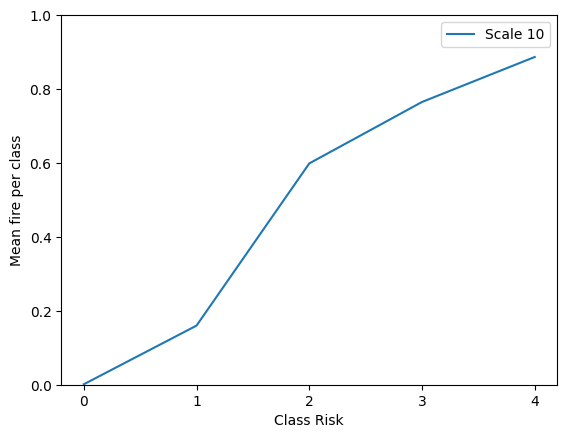

In [21]:
for sc in scales:
    plt.plot(np.arange(5), means[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylim(0, 1)
plt.ylabel('Mean fire per class')
plt.xlabel('Class Risk')
plt.legend()

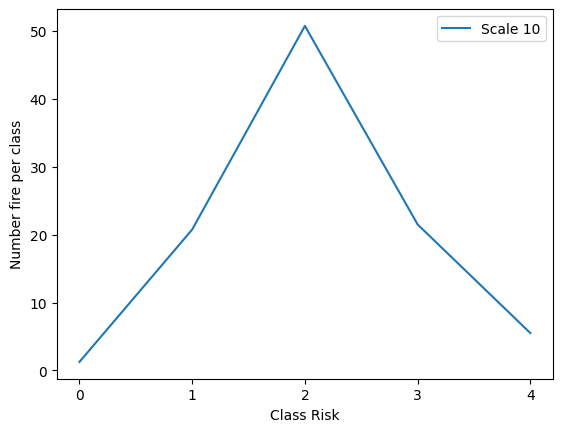

In [22]:
for sc in scales:
    plt.plot(np.arange(5), means2[sc],label='Scale ' + sc)

plt.xticks([0,1,2,3,4])
plt.ylabel('Number fire per class')
plt.xlabel('Class Risk')
plt.legend()

(141932, 328)


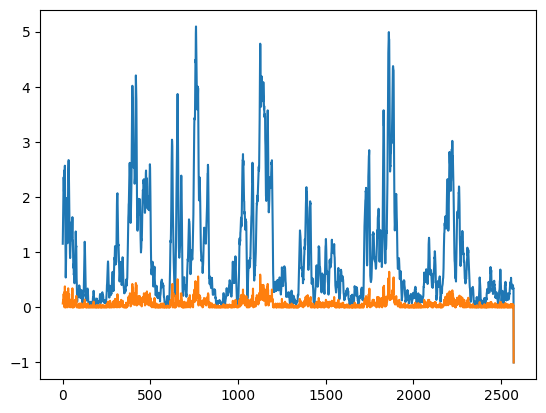

In [11]:
name_exp = 'inference'
sinister = 'firepoint'

Y = read_object('Y_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
X = read_object('X_full_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
X2 = np.copy(X)
Y2 = np.copy(Y)
print(X.shape)
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
pos_feature, _ = create_pos_feature(10, 6, features)
Y_by_date = []
Y_fire = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    Y_fire.append(np.mean(Y[Y[:,4] == d][:, -2]))
    
Y_by_date = np.asarray(Y_by_date)
Y_fire = np.asarray(Y_fire)
plt.plot(Y_by_date)

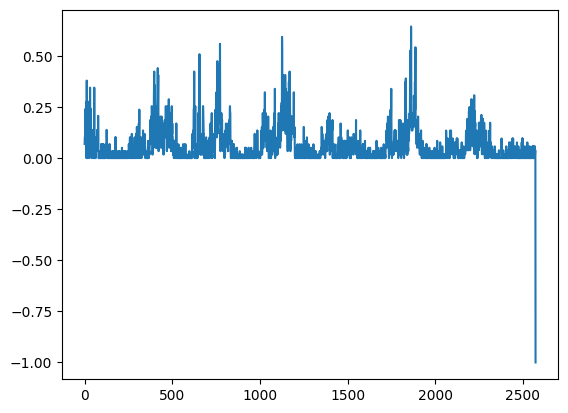

In [12]:
plt.plot(Y_fire)

In [50]:
np.sum(Y2[Y2[:, 3] == 1][:, -2]), np.sum(Y2[Y2[:, 3] == 25][:, -2]), np.sum(Y2[Y2[:, 3] == 69][:, -2]), np.sum(Y2[Y2[:, 3] == 78][:, -2])

(2989.0, 2295.0, 968.0, 2624.0)

2024-07-06 10:38:17,204 [INFO ]  final/firepoint/train/graph_10.pkl not found
(142171, 328) (141932, 9)
7784.575719082877


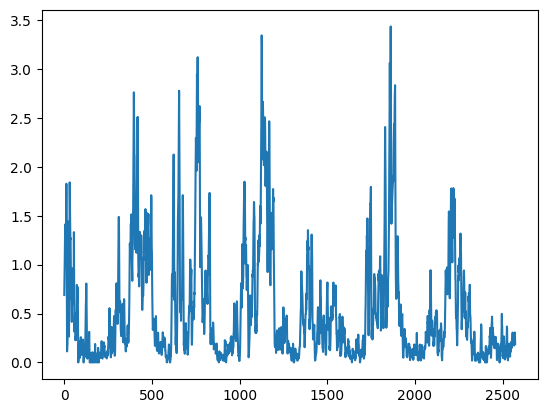

In [4]:
name_exp = 'final'
sinister = 'firepoint'

Y = read_object('Y_full_10.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train'))
X = read_object('X_full_10.pkl', Path(name_exp + '/' + sinister + '/' +'2x2' + '/' + 'train'))
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'train'))
print(X.shape, Y.shape)
pos_feature, _ = create_pos_feature(10, 6, features)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    
Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)
print(np.sum(Y[:, -2]))

8301.0
5097.0


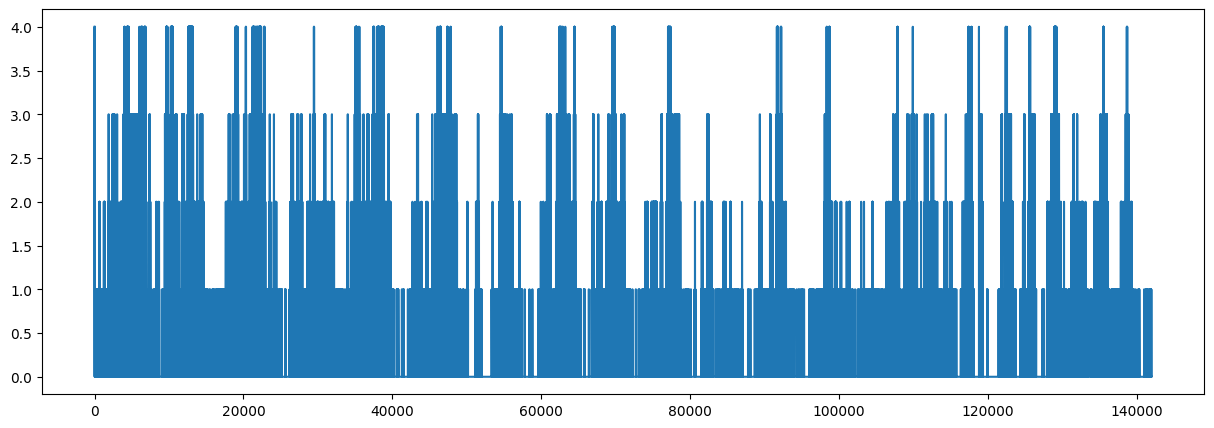

In [7]:
plt.figure(figsize=(15,5))
plt.plot(Y[:, -3])
#plt.plot(Y[:, -1])
print(np.sum(Y[:, -2]))
print(np.sum(Y[Y[:, 3] == 78][:, -3]))

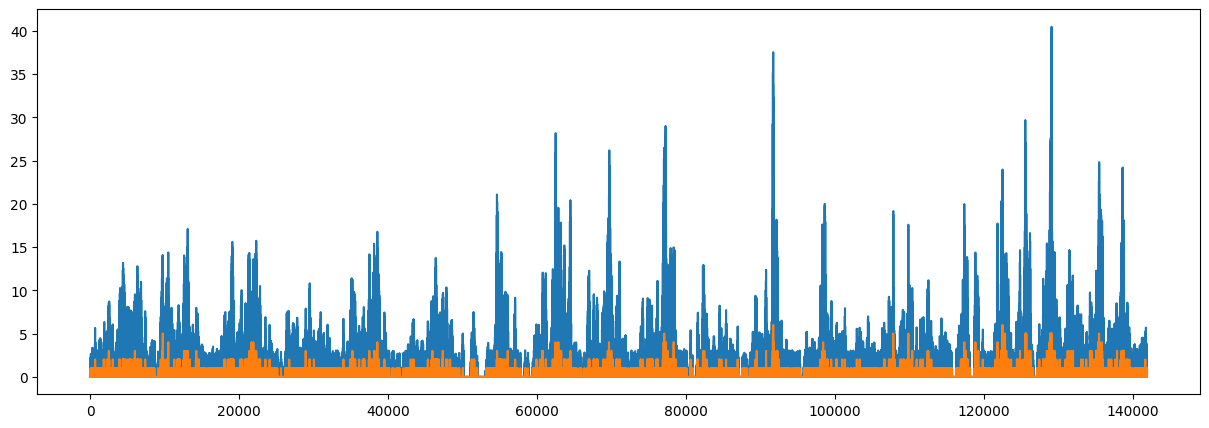

In [8]:
plt.figure(figsize=(15,5))
plt.plot(Y[:, -1])
plt.plot(Y[:, -2])

(array([52066.,  5868., 45265., 38681.]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

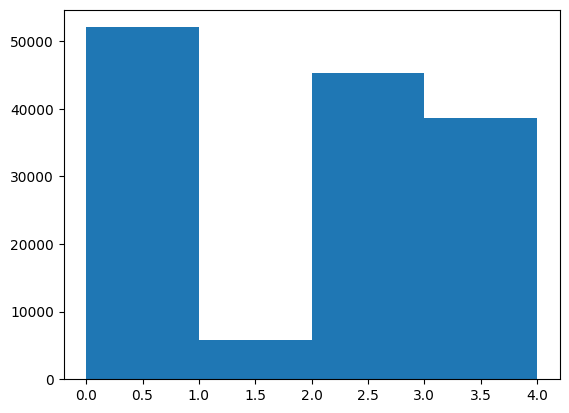

In [16]:
plt.hist(Y[:, -3], bins=[0,1,2,3,4])

In [54]:
np.sum(Y[Y[:, 3] == 1][:, -2]), np.sum(Y[Y[:, 3] == 25][:, -2]), np.sum(Y[Y[:, 3] == 69][:, -2]), np.sum(Y[Y[:, 3] == 78][:, -2])

(2882.0, 2179.0, 969.0, 2547.0)

In [24]:
np.min(X[X[:, 3] == 69][:, 4])

203.0

In [26]:
allDates[203]

'2018-01-01'

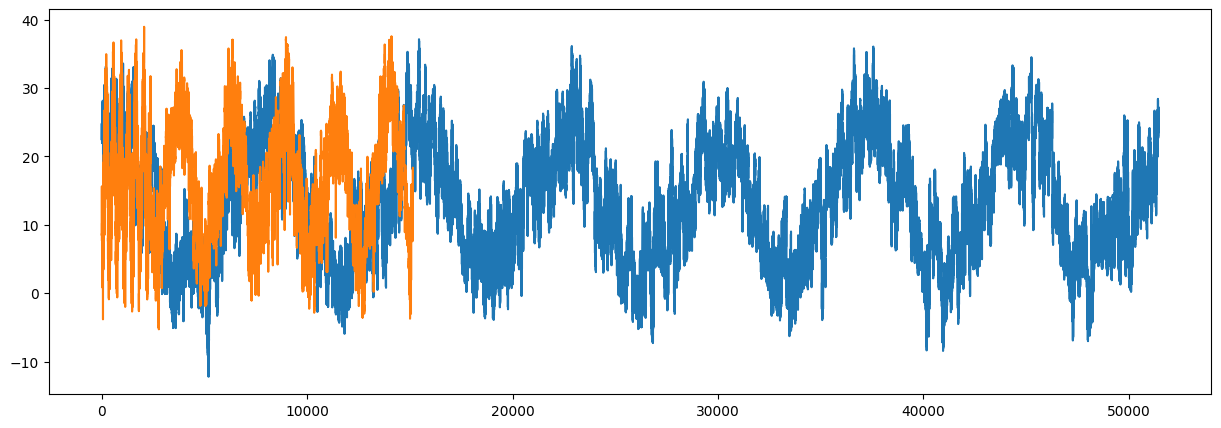

In [28]:
plt.figure(figsize=(15,5))
plt.plot(X[X[:, 3] == 25][:, 6])
plt.plot(X[X[:, 3] == 69][:, 6])

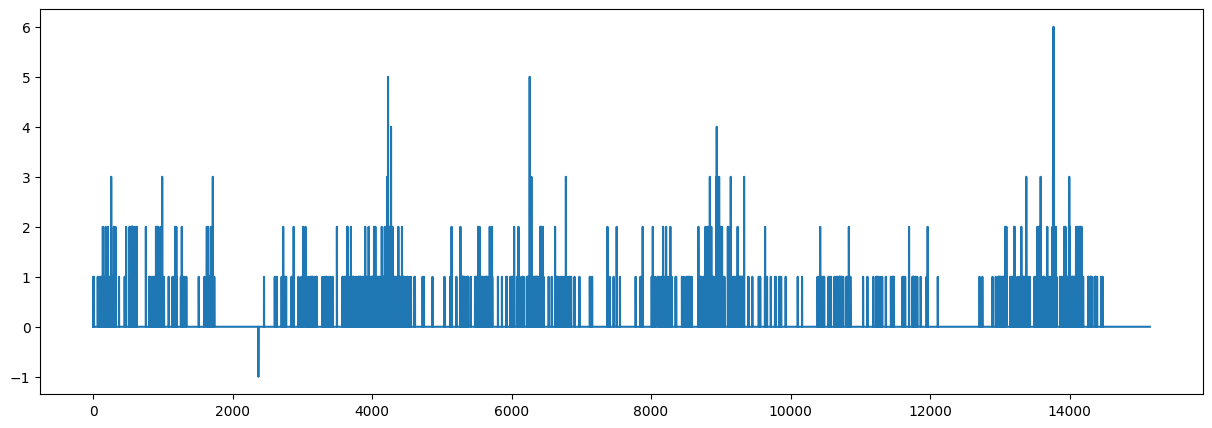

In [17]:
plt.figure(figsize=(15,5))
plt.plot(Y[Y[:, 3] == 69][:, -2])
#plt.plot(Y2[Y2[:, 3] == 25][:, -2])

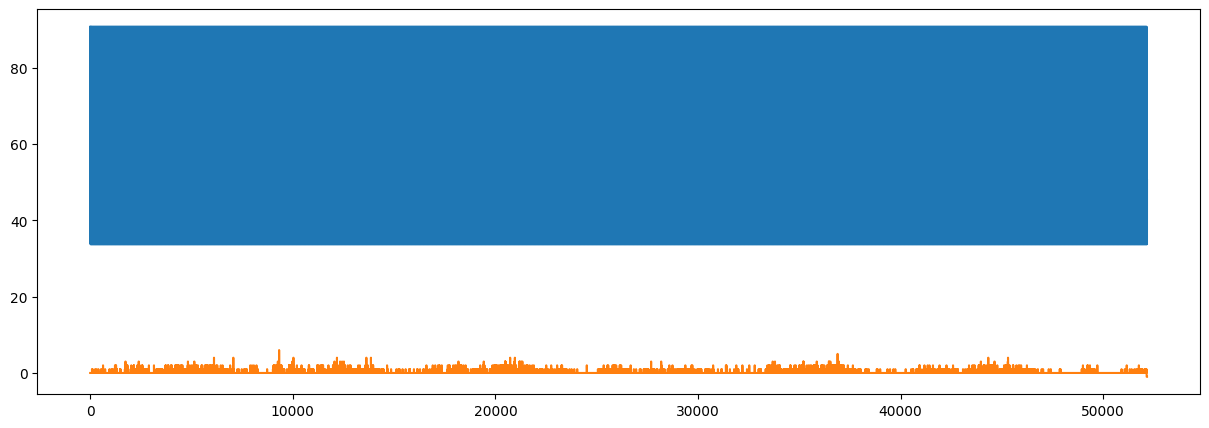

In [16]:
plt.figure(figsize=(15,5))
plt.plot(X[X[:, 3] == 1][:, pos_feature['foret']])
plt.plot(Y2[Y2[:, 3] == 1][:, -2])

(13156, 324)


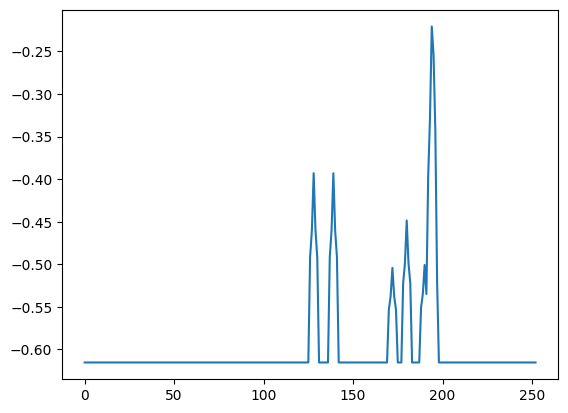

In [ ]:
name_exp = 'exp1'
sinister = 'inondation'

Y = read_object('Y_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
X = read_object('X_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
Xset = read_object('Xset.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
print(X.shape)
graph = read_object('graph_10.pkl', Path(name_exp + '/' + sinister + '/' + 'test/2023'))
pos_feature, _ = create_pos_feature(graph, 6, features)
Y_by_date = []
udates = np.unique(Y[:,4])
for d in udates:
    Y_by_date.append(np.mean(Y[Y[:,4] == d][:, -1]))
    
Y_by_date = np.asarray(Y_by_date)
plt.plot(Y_by_date)

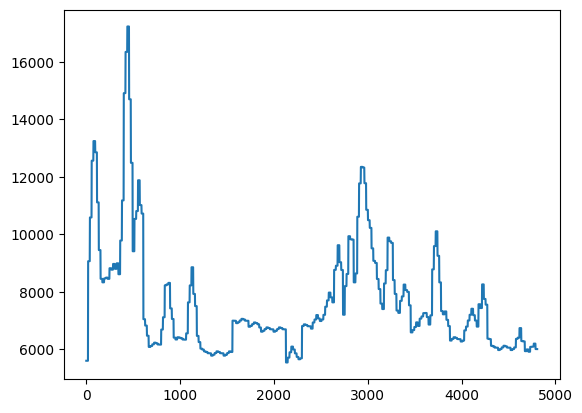

In [ ]:
plt.plot(Xset[:,300])

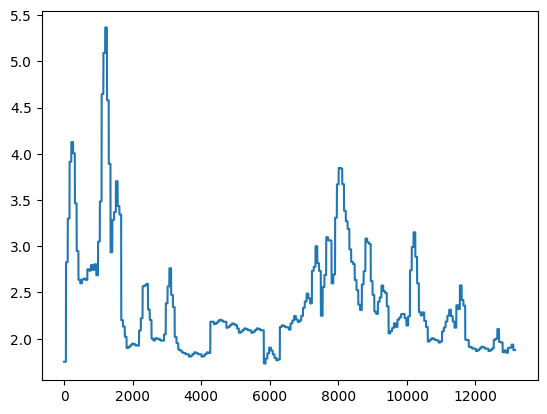

In [ ]:
plt.plot(X[:,pos_feature['Calendar'] + 14 ])

In [ ]:
print(np.nanmax(Xset))

17227.711612001534
